In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
from pls_m4 import *
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [2]:
df_orig = pd.read_csv('final_data_files/uncrowded_photometry.csv')
df_orig.mag_4[df_orig.id==122] = -2.5*np.log10(np.mean(10**(df_orig.mag_4[df_orig.id==122] / -2.5)))
df_orig.merr_4[df_orig.id==122] = np.mean(df_orig.merr_4[df_orig.id==122]) / np.sqrt(2)
df_orig = df_orig.drop_duplicates()

In [3]:
for label in ['j', 'h', 'k', '3', '4']:
    print label, len(df_orig['mag_{}'.format(label)][np.isfinite(df_orig['mag_{}'.format(label)])])

j 96
h 96
k 98
3 36
4 42


In [4]:
bad_ids = [103, 107]#, 40, 169]#, 169] #120, , 357
df_bad = df_orig[df_orig.id.isin(bad_ids)]
df_bad_ab = df_bad[df_bad.type == 0]
df_bad_c = df_bad[df_bad.type == 1]

df = df_orig[~df_orig.id.isin(bad_ids)]

In [9]:
# things for plotting loop
funcs = [j_ab, j_c, h_ab, h_c, k_ab, k_c, t_ab, t_c, f_ab, f_c]
band_labels = ['j', 'h', 'k', '3', '4']
band_names = ['J', 'H', 'K_s', '[3.6]', '[4.5]']
cmap = plt.cm.get_cmap('gist_rainbow')
plot_colors = list(reversed([cmap(i) for i in np.linspace(0,0.91,len(band_labels))]))
mag_offset = [8, 6, 4, 2, 0]
wavelength = [1.220, 1.630, 2.190, 3.550, 4.493]

In [10]:
print feh_ab, feh_c

-1.67662162162 -1.67662162162


In [11]:
# select only the rows with photometry for all bands
df1 = df[(np.isfinite(df.mag_j)) & (np.isfinite(df.mag_h)) & (np.isfinite(df.mag_k)) &
        (np.isfinite(df.mag_3)) & (np.isfinite(df.mag_4))]

J ab 13.8646216045 0.0232872262964 c 13.8661279199 0.0189502560191
H ab 13.8206882649 0.0324757956667 c 13.8441182413 0.0255601206655
K_s ab 13.8159148711 0.0252456468356 c 13.8311253461 0.0210288688987
[3.6] ab 13.7503311889 0.0264515689129 c 13.8380616047 0.0308651734852
[4.5] ab 13.7708312102 0.0521525603163 c 13.8897564007 0.0608458717668


/Users/mdurbin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mdurbin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


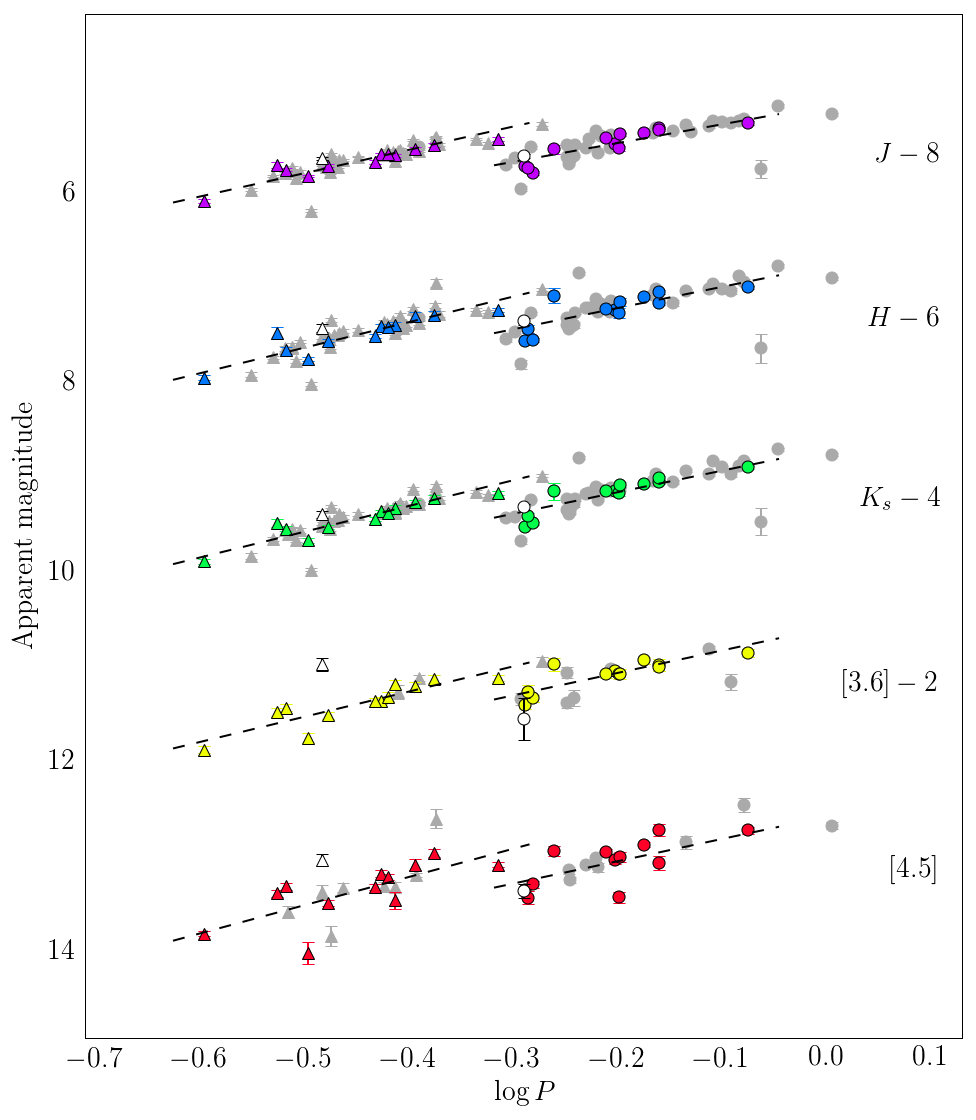

In [12]:
fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(14.9, 4.1)
ax.set_xlim(-0.71, 0.13)

# separate full and cut sample dataframes into abs and cs
df_ab = df[df.type == 0]
df_c = df[df.type == 1]

df1_ab = df1[df1.type == 0]
df1_c = df1[df1.type == 1]

dmod_prior = 14.
feh = -1.56749344383

per_ab = np.log10(df1_ab.per)
per_c = np.log10(df1_c.per)
xspace_ab = np.linspace(np.min(per_ab) - 0.03, np.max(per_ab) + 0.03, 100)
xspace_c = np.linspace(np.min(per_c) - 0.03, np.max(per_c) + 0.03, 100)

distance_df = {}
distance_df['wavelength'] = wavelength
distance_df['dist_ab'] = []
distance_df['dist_c'] = []
distance_df['err_ab'] = []
distance_df['err_c'] = []

for i in range(5):
    mag_ab = df1_ab['mag_' + band_labels[i]]
    merr_ab = df1_ab['merr_' + band_labels[i]]
    mag_c = df1_c['mag_' + band_labels[i]]
    merr_c = df1_c['merr_' + band_labels[i]]
    
    # do the fitting
    popt_ab, pcov_ab = curve_fit(funcs[i*2], per_ab, mag_ab, p0 = dmod_prior)
    popt_c, pcov_c = curve_fit(funcs[i*2 + 1], per_c, mag_c, p0 = dmod_prior)
    dist_ab, err_ab = popt_ab[0], np.sqrt(np.diag(pcov_ab))[0]
    dist_c, err_c = popt_c[0], np.sqrt(np.diag(pcov_c))[0]
    
    distance_df['dist_ab'].append(dist_ab)
    distance_df['err_ab'].append(err_ab)
    distance_df['dist_c'].append(dist_c)
    distance_df['err_c'].append(err_c)
    
    # fit lines for plotting + get residuals
    linfit_ab = funcs[i*2](xspace_ab, dist_ab)
    resid_ab = funcs[i*2](per_ab, dist_ab) - mag_ab
    linfit_c = funcs[i*2 + 1](xspace_c, dist_c)
    resid_c = funcs[i*2 + 1](per_c, dist_c) - mag_c
    
    df1_ab['resid_m4_' + band_labels[i]] = resid_ab
    df1_c['resid_m4_' + band_labels[i]] = resid_c

    print band_names[i], 'ab', dist_ab, err_ab, 'c', dist_c, err_c
    
    # plot full sample in grey
    plt.errorbar(np.log10(df_ab.per), df_ab['mag_' + band_labels[i]] - mag_offset[i],
                 yerr=df_ab['merr_' + band_labels[i]].values, fmt='o', color='#AAAAAA',
                 mec='#AAAAAA', zorder=-1)
    plt.errorbar(np.log10(df_c.per), df_c['mag_' + band_labels[i]] - mag_offset[i],
                 yerr=df_c['merr_' + band_labels[i]].values, fmt='^', color='#AAAAAA',
                 mec='#AAAAAA', zorder=-1)

    #err_wtf = df_bad_ab['merr_' + band_labels[i]].values
                     
    plt.errorbar(np.log10(df_bad_ab.per), df_bad_ab['mag_' + band_labels[i]] - mag_offset[i],
                 yerr=df_bad_ab['merr_' + band_labels[i]].values, fmt='o', color='k',
                 mfc='w', zorder=10)
    plt.errorbar(np.log10(df_bad_c.per), df_bad_c['mag_' + band_labels[i]] - mag_offset[i],
                 yerr=df_bad_c['merr_' + band_labels[i]].values, fmt='^', color='k',
                 mfc='w', zorder=10)
    

    # plot cut sample in color
    plt.errorbar(per_ab, mag_ab - mag_offset[i], yerr=merr_ab, fmt='o', color=plot_colors[i])
    plt.errorbar(per_c.values, mag_c.values - mag_offset[i], yerr=merr_c.values, fmt='^', color=plot_colors[i])
    
    ppl.plot(xspace_ab, linfit_ab - mag_offset[i], 'k--', lw=1)
    ppl.plot(xspace_c, linfit_c - mag_offset[i], 'k--', lw=1)
    
    # add labels
    if mag_offset[i] == 0:
        plt.text(ax.get_xlim()[1] - 0.02, np.median(mag_ab - mag_offset[i] + 0.2),
                 '${}$'.format(band_names[i]), ha='right')
    else:
        plt.text(ax.get_xlim()[1] - 0.02, np.median(mag_ab - mag_offset[i] + 0.2),
                 '${} - {}$'.format(band_names[i], mag_offset[i]), ha='right')

ax.set_ylabel('Apparent magnitude')
ax.set_xlabel(r'$\log P$')
fig.tight_layout()
fig.savefig('final_plots/multiwavelength_PL_m4_clipped.pdf')

In [ ]:
# make table of distances

weight_ab = len(per_ab)/float(len(df1))
weight_c = len(per_c)/float(len(df1))

distance_df['dist_mean'] = np.asarray(distance_df['dist_ab']) * weight_ab + \
                           np.asarray(distance_df['dist_c']) * weight_c
distance_df['err_mean'] = np.sqrt((np.asarray(distance_df['err_ab']) * weight_ab)**2 + \
                          (np.asarray(distance_df['err_c']) * weight_c)**2)
distance_df = pd.DataFrame.from_dict(distance_df)
distance_df = distance_df[['wavelength','dist_ab','err_ab','dist_c','err_c','dist_mean','err_mean']]
distance_df.to_csv('final_data_files/dist_spect_m4_clipped.csv', index=False)

In [ ]:
# incorporate residuals into full table and save

df1_withresid = pd.concat([df1_ab, df1_c])
df_withresid = df_orig.merge(df1_withresid, how='outer', on=list(set(df.keys()) & set(df1_withresid.keys())))
df_withresid.sort('id', inplace=True)
df_withresid.to_csv('final_data_files/uncrowded_withresid_m4_clipped.csv', index=False)